In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn=engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

   id      station        date  prcp  tobs
0   1  USC00519397  2010-01-01  0.08  65.0
latestdata=2017-08-23 00:00:00
dateayearago=2016-08-23 00:00:00


(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.,
        2250.]), <a list of 10 Text xticklabel objects>)

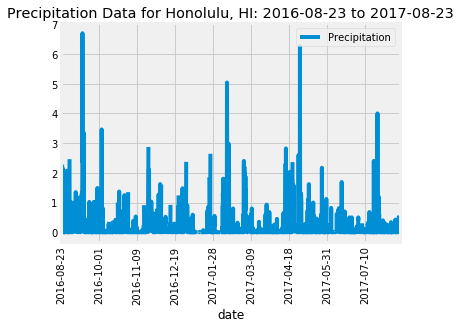

In [10]:
# Find out the most recent date in the measurement db
df=pd.read_sql("select * from measurement[1]", conn)
print(df.head(1))
df.sort_values(by=['date'],inplace=True, ascending=False)
df['date'] = pd.to_datetime(df['date'])
latestdate = (df["date"].max())
print(f'latestdata={latestdate}')

# Calculate the date 1 year ago from the last data point in the database
dateayearago = latestdate - dt.timedelta(days=365)
print(f'dateayearago={dateayearago}')

# Perform a query to retrieve the data and precipitation scores, and save as pandas dataframe
df2=pd.read_sql('select measurement.date, measurement.prcp from measurement where measurement.date between "2016-08-23" and "2017-08-23"', conn)

# set the index to the date column
df2 = df2.set_index('date')

# Sort the dataframe by date in an ascending order
df2.sort_values(by=['date'],inplace=True, ascending=True)

#Rename the prcp column to match the graph shown in the starter code notebook
df2=df2.rename(columns={"prcp": "Precipitation"})

# Use Pandas Plotting with Matplotlib to plot the data
df2.plot(title="Precipitation Data for Honolulu, HI: 2016-08-23 to 2017-08-23")
plt.tight_layout()
plt.xticks(rotation=90)

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df2.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
df3 = pd.read_sql("Select * from station", conn)
numberofstns = (df3['station'].nunique())
print(f'Number of Stations = {numberofstns}')

Number of Stations = 9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# The value_counts panda function automatically lists it all in a descending order
#df creared earlier was used to get the station row count
df4 = df["station"].value_counts()
print(df4)

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
mostactive = df4.index.values[0]
print(f'Most Active Station:{mostactive}')
df5= df[(df["station"]==mostactive)]
# Sort the dataframe by date in an ascending order
mintemp=df5["tobs"].min()
print(f'Lowest Temp. recorded:{mintemp}')
maxtemp=df5["tobs"].max()
print(f'Highest Temp. recorded:{maxtemp}')
avgtemp=df5["tobs"].mean()
print(f'Average Temp. recorded:{round(avgtemp,1)}')

Most Active Station:USC00519281
Lowest Temp. recorded:54.0
Highest Temp. recorded:85.0
Average Temp. recorded:71.7


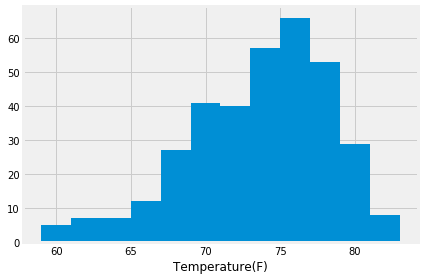

<Figure size 432x288 with 0 Axes>

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Perform a query to retrieve the data and temp. observations, and save as pandas dataframe
df6=pd.read_sql('select measurement.date, measurement.tobs, measurement.station from measurement where measurement.date between "2016-08-23" and "2017-08-23"', conn)

#filter to just keep data for the "most active" station
df6 = df6[df6['station']==mostactive]
# set the index to the date column
df6 = df6.set_index('date')


# Sort the dataframe by date in an ascending order

df6.sort_values(by=['date'],inplace=True, ascending=True)

plt.hist(df6['tobs'], bins=12)
plt.xlabel("Temperature(F)")
plt.tight_layout()
plt.show()
plt.savefig("Temmp. Histogram.jpeg")


![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#convert date strings to dateobjects
start = '2019-07-04'
end = '2019-07-14'
start=dt.datetime.strptime(start,'%Y-%m-%d')
end=dt.datetime.strptime(end,'%Y-%m-%d')

#subtract 2 years (365*2 days) from start and end dates for the trip since data is only available till 2017-07-23
start2yearsago = start.date() - dt.timedelta(days=(365*2))
end2yearsago = end.date() - dt.timedelta(days=(365*2))

# define a new variable to store tmin,tavg, tmax for the desired vacation period
vacation_temps = calc_temps(start2yearsago, end2yearsago)
print(f'Vacation Temperatures (Min. Temp., Avg. Temp., Max. Temp in degrees F): {vacation_temps}')


Vacation Temperatures (Min. Temp., Avg. Temp., Max. Temp in degrees F): [(69.0, 77.94285714285714, 82.0)]


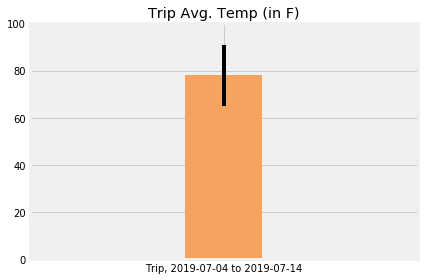

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
mintemp = float(vacation_temps[0][0])
maxtemp = float(vacation_temps[0][2])
avgtemp = vacation_temps[0][1]

errorbar = np.array([maxtemp-mintemp])

plt.bar('Trip, 2019-07-04 to 2019-07-14', avgtemp, yerr=errorbar, color = 'sandybrown')
plt.xlim(-2,2)
plt.ylim(0,100)
plt.title("Trip Avg. Temp (in F)")
plt.tight_layout()
plt.savefig("Avg. Temp Bar Chart (with Error Bars).jpeg")

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

df7=pd.read_sql('select measurement.date, measurement.station, measurement.prcp, station.name, station.latitude, station.longitude, station.elevation from measurement inner join station on measurement.station = station.station', conn)
df7['date']=pd.to_datetime(df['date'])
# set the index to the date column so data can be filtered for the period of interest
df7 = df7.set_index('date')
df7.sort_values(by=['date'],inplace=True, ascending=True)
df7.head()
#filter based on dates/period of interest
df8=df7.loc[start2yearsago:end2yearsago]
# #reset index to normal
df8.reset_index()
#drop rows containing null values in the 'prcp' column
df8.dropna(subset=['prcp']).reset_index()
#use groupby to calculate total rainfall for the period
df9 = df8.groupby(["station","name","latitude","longitude","elevation"])["prcp"].sum().reset_index()
df9.sort_values(by=['prcp'],inplace=True, ascending=False)
df9.reset_index(drop=True)
df9.head()







,station,name,latitude,longitude,elevation,prcp
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.77
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.21
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.56
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.38
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.13


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# The start and end date of the trip were already saved under variables(as datetime objects) called "Start" and "End" earlier
#create a list called 'dates' to hold the mm-dd for dates between the start and the end date
dates=[]

#daterange function below creates a list of all dates between start date and end date
from datetime import timedelta
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

# Using the daterange function above, create a range of dates of interest in mm-dd format
for dt in daterange(start, end):
    dates.append(dt.strftime("%m-%d"))

print(f'Dates of interest:{dates}')
# Loop through the list of %m-%d strings stored in the 'dates' list and calculate the normals for each date
Normals=[daily_normals(date) for date in dates]

Normals

#Normals is a list of a list of tuples. The code below allows its conversion to just a list of tuples,
#a list of tuples is very easy to convert to dataframe
flattened_Normals = []
for sublist in Normals:
    for item in sublist:
        flattened_Normals.append(item)
        
flattened_Normals
        


Dates of interest:['07-04', '07-05', '07-06', '07-07', '07-08', '07-09', '07-10', '07-11', '07-12', '07-13', '07-14']


[(70.0, 76.57142857142857, 81.0),
 (66.0, 75.0, 81.0),
 (69.0, 75.0, 81.0),
 (69.0, 74.91071428571429, 82.0),
 (69.0, 76.08333333333333, 83.0),
 (68.0, 76.19298245614036, 83.0),
 (68.0, 75.62068965517241, 82.0),
 (70.0, 75.78947368421052, 81.0),
 (67.0, 75.96491228070175, 82.0),
 (69.0, 76.1896551724138, 81.0),
 (61.0, 76.2280701754386, 82.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame, define column names 
df10=pd.DataFrame(flattened_Normals,columns=['Min. Temp(F)','Avg. Temp(F)','Max. Temp(F)'])
#Add the `dates` list to the df and then set it as the index
df10['date']=dates
df10.set_index('date')


,Min. Temp(F),Avg. Temp(F),Max. Temp(F)
date,,,
07-04,70.0,76.571429,81.0
07-05,66.0,75.000000,81.0
07-06,69.0,75.000000,81.0
07-07,69.0,74.910714,82.0
07-08,69.0,76.083333,83.0
07-09,68.0,76.192982,83.0
07-10,68.0,75.620690,82.0
07-11,70.0,75.789474,81.0
07-12,67.0,75.964912,82.0


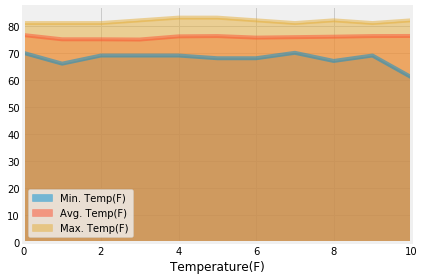

<Figure size 432x288 with 0 Axes>

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
df10.plot.area(stacked=False)
plt.xlabel("Temperature(F)")
plt.tight_layout()
plt.show()
plt.savefig("Area Plot of Temperatures.jpeg")